In [1]:
using LinearAlgebra
using Plots,LaTeXStrings
using Polynomials
include("FNC.jl")

Main.FNC

# Example 3.1.1

Here are 5-year averages of the worldwide temperature anomaly as compared to the 1951-1980 average (source: NASA).

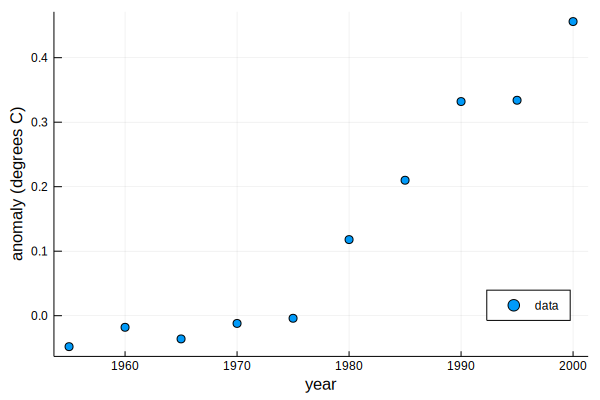

In [2]:
t = 1955:5:2000
y = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
    0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ];
    
scatter(t,y,label="data",
    xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)

A polynomial interpolant can be used to fit the data. Here we build one using a Vandermonde matrix. First, though, we express time as decades since 1950, as it improves the condition number of the matrix. 

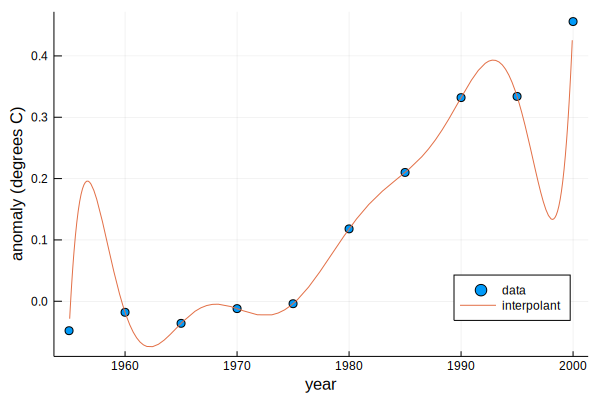

In [3]:
t = @. (t-1950)/10; 
V = [ t[i]^j for i=1:length(t), j=0:length(t)-1 ]
c = V\y

p = Poly(c)
f = s -> p((s-1950)/10)
plot!(f,1955,2000,label="interpolant")

As you can see, the interpolant does represent the data, in a sense. However it's a crazy-looking curve for the application. Trying too hard to reproduce all the data exactly is known as _overfitting_.

# Example 3.1.2

Here are the 5-year temperature averages again.

In [4]:
year = 1955:5:2000
t = year .- 1955;
y = [ -0.0480, -0.0180, -0.0360, -0.0120, -0.0040,
    0.1180, 0.2100, 0.3320, 0.3340, 0.4560 ];

The standard best-fit line results from using a linear polynomial that meets the least squares criterion. 

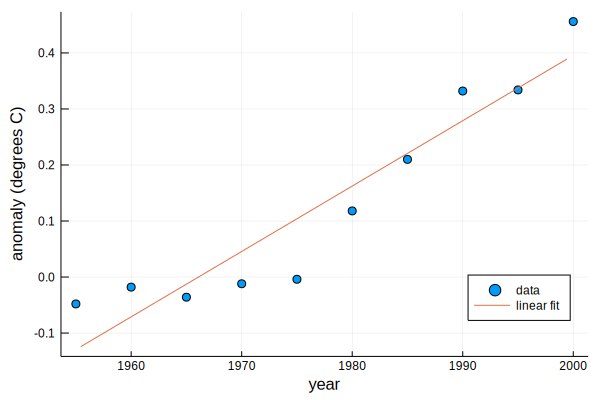

In [5]:
V = [ t.^0 t ]    # Vandermonde-ish matrix
c = V\y
p = Poly(c)

f = s -> p(s-1955)
scatter(year,y,label="data",
    xlabel="year",ylabel="anomaly (degrees C)",leg=:bottomright)
plot!(f,1955,2000,label="linear fit")

If we use a global cubic polynomial, the points are fit more closely.

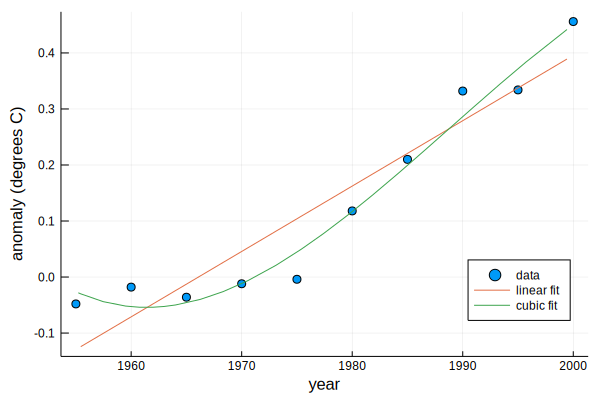

In [6]:
V = [ t[i]^j for i=1:length(t), j=0:3 ]   # Vandermonde-ish matrix
p = Poly( V\y )
f = s -> p(s-1955)
plot!(f,1955,2000,label="cubic fit")

If we were to continue increasing the degree of the polynomial, the residual at the data points would get smaller, but overfitting would increase.

# Example 3.1.3

Finding numerical approximations to $\pi$ has fascinated people for millenia. One famous formula is

$$ \frac{\pi^2}{6} = 1 + \frac{1}{2^2} + \frac{1}{3^2} + \cdots. $$


Say $s_k$ is the sum of the first  terms of the series above, and $p_k = \sqrt{6s_k}$. Here is a fancy way to compute these sequences in a compact code.

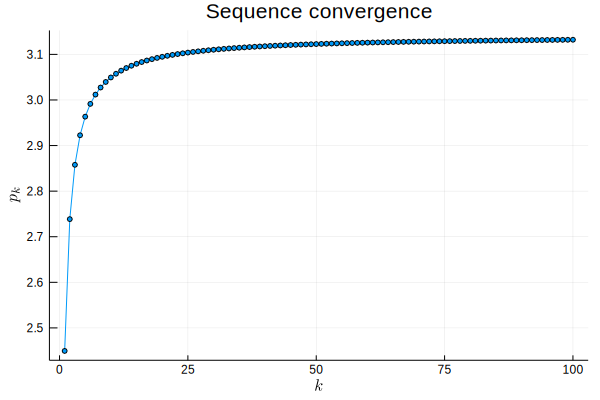

In [7]:
a = [1/k^2 for k=1:100] 
s = cumsum(a)        # cumulative summation
p = @. sqrt(6*s)

plot(1:100,p,m=(:o,2),leg=:none,xlabel=L"k",ylabel=L"p_k",title="Sequence convergence")

This graph suggests that $p_k\to \pi$ but doesn't give much information about the rate of convergence. Let $\epsilon_k=|\pi-p_k|$ be the sequence of errors. By plotting the error sequence on a log-log scale, we can see a nearly linear relationship.

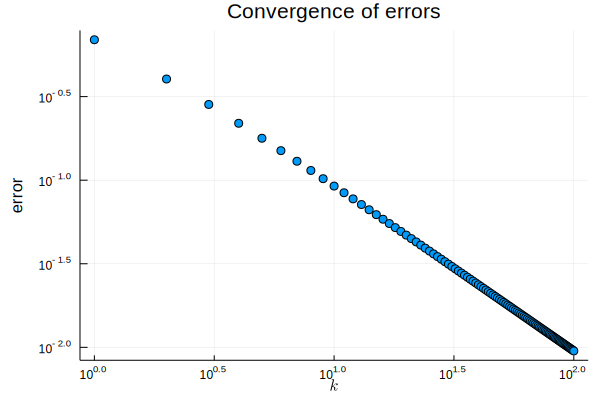

In [8]:
ep = @. abs(pi-p)    # error sequence
scatter(1:100,ep,
    leg=:none,xaxis=(:log10,L"k"),yaxis=(:log10,"error"),title="Convergence of errors")

This suggests a power-law relationship where $\epsilon_k\approx a k^b$, or $\log \epsilon_k \approx b (\log k) + \log a$.

In [9]:
k = 1:100
V = [ k.^0 log.(k) ]     # fitting matrix
c = V \ log.(ep)         # coefficients of linear fit

2-element Array{Float64,1}:
 -0.1823752497283019
 -0.9674103233127926

In terms of the parameters $a$ and $b$ used above, we have 

In [10]:
@show (a,b) = exp(c[1]),c[2];

(a, b) = (exp(c[1]), c[2]) = (0.8332885904225771, -0.9674103233127926)


It's tempting to conjecture that $b\to -1$ asymptotically. Here is how the numerical fit compares to the original convergence curve. 

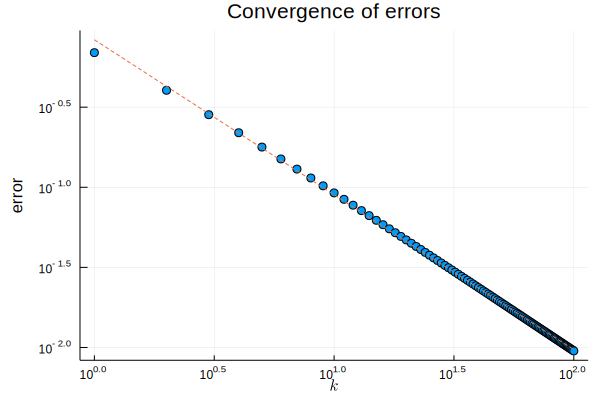

In [11]:
plot!(k,a*k.^b,l=:dash)

# Example 3.2.1

Because the functions $\sin^2(t)$, $\cos^2(t)$, and $1$ are linearly dependent, we should find that the following matrix is somewhat ill-conditioned.

In [12]:
t = range(0,stop=3,length=400)
A = [ sin.(t).^2 cos.((1+1e-7)*t).^2 t.^0 ]
kappa = cond(A)

1.825322542299846e7

Now we set up an artificial linear least squares problem with a known exact solution that actually makes the residual zero.

In [13]:
x = [1.,2,1]
b = A*x;

Using backslash to find the solution, we get a relative error that is about $\kappa$ times machine epsilon.

In [14]:
x_BS = A\b
@show observed_err = norm(x_BS-x)/norm(x);
@show max_err = kappa*eps();

observed_err = norm(x_BS - x) / norm(x) = 4.323244351350582e-11
max_err = kappa * eps() = 4.05303022765723e-9


If we formulate and solve via the normal equations, we get a much larger relative error. With $\kappa^2\approx 10^{14}$, we may not be left with more than about 2 accurate digits.

In [15]:
N = A'*A
x_NE = N\(A'*b)
@show observed_err = norm(x_NE-x)/norm(x)
@show digits = -log(10,observed_err)

observed_err = norm(x_NE - x) / norm(x) = 0.003626188496847509
digits = -(log(10, observed_err)) = 2.440549624119996


2.440549624119996

# Example 3.3.1

Julia provides access to both the thin and full forms of the QR factorization.

In [16]:
A = rand(1.:9.,6,4)
@show m,n = size(A);

(m, n) = size(A) = (6, 4)


Here is a standard call:

In [17]:
Q,R = qr(A);
Q

6×6 LinearAlgebra.QRCompactWYQ{Float64,Array{Float64,2}}:
 -0.80904   0.222275    0.50595    0.0714732  -0.0551998   0.178627 
 -0.26968  -0.115445   -0.143602   0.0763062  -0.434557   -0.83586  
 -0.26968   0.16886    -0.552267  -0.631038   -0.342902    0.279231 
 -0.13484  -0.673717    0.246143  -0.579956    0.336377   -0.133557 
 -0.40452  -0.0310151  -0.574507   0.280397    0.648555   -0.0780831
 -0.13484  -0.673717   -0.166583   0.41939    -0.395927    0.4093   

In [18]:
R

4×4 Array{Float64,2}:
 -7.4162  -14.0234  -8.22524  -7.28136
  0.0     -10.552   -3.37893  -2.83271
  0.0       0.0     -9.69166  -7.6909 
  0.0       0.0      0.0      -5.17761

If you look carefully, you see that we got a full $Q$ but a thin $R$. Moreover, the $Q$ above is not a standard matrix type. If you convert it to a true matrix, then it reverts to the thin form. 

In [19]:
Matrix(Q)

6×4 Array{Float64,2}:
 -0.80904   0.222275    0.50595    0.0714732
 -0.26968  -0.115445   -0.143602   0.0763062
 -0.26968   0.16886    -0.552267  -0.631038 
 -0.13484  -0.673717    0.246143  -0.579956 
 -0.40452  -0.0310151  -0.574507   0.280397 
 -0.13484  -0.673717   -0.166583   0.41939  

We can test that $\mathbf{Q}$ is orthogonal.

In [20]:
QTQ = Q'*Q
norm(QTQ - I)

6.463236069784172e-16

The thin $Q$ cannot be an orthogonal matrix, because it is not even square, but it is still ONC.

In [21]:
Matrix(Q)'*Matrix(Q) - I

4×4 Array{Float64,2}:
  0.0          -4.95154e-17  -7.24414e-17  -5.36764e-17
 -4.95154e-17   0.0           5.36652e-17  -8.07209e-17
 -7.24414e-17   5.36652e-17   4.44089e-16   1.6833e-16 
 -5.36764e-17  -8.07209e-17   1.6833e-16   -2.22045e-16

# Example 3.4.1

We will use Householder reflections to produce a QR factorization of the matrix

In [22]:
A = rand(1.:9.,6,4)
m,n = size(A)

(6, 4)

Our first step is to introduce zeros below the diagonal in column 1. Define the vector 

In [23]:
z = A[:,1];

Applying the Householder definitions gives us

In [24]:
v = z - norm(z)*[1;zeros(m-1)]
P = I - 2/(v'*v)*(v*v')   # reflector

6×6 Array{Float64,2}:
 0.552866   0.552866   0.552866   0.184289    0.122859    0.184289 
 0.552866   0.316402  -0.683598  -0.227866   -0.151911   -0.227866 
 0.552866  -0.683598   0.316402  -0.227866   -0.151911   -0.227866 
 0.184289  -0.227866  -0.227866   0.924045   -0.0506369  -0.0759554
 0.122859  -0.151911  -0.151911  -0.0506369   0.966242   -0.0506369
 0.184289  -0.227866  -0.227866  -0.0759554  -0.0506369   0.924045 

(Julia automatically fills in an identity of the correct size for the `I` above.) By design we can use the reflector to get the zero structure we seek:

In [25]:
P*z

6-element Array{Float64,1}:
 16.278820596099706     
 -2.220446049250313e-16 
 -2.220446049250313e-16 
  1.6653345369377348e-16
  1.1102230246251565e-16
  4.440892098500626e-16 

Now we let 

In [26]:
A = P*A

6×4 Array{Float64,2}:
 16.2788        8.47727   7.61726    9.89015 
 -1.94289e-16   1.93694  -3.94554    0.480576
 -1.94289e-16  -2.06306  -1.94554   -5.51942 
  5.55112e-17   4.97898   4.68482   -1.83981 
 -3.33067e-16   2.31932   0.456547  -0.893205
  4.44089e-16   0.97898   0.68482    4.16019 

We are set to put zeros into column 2. We must not use row 1 in any way, lest it destroy the zeros we just introduced. To put it another way, we can repeat the process we just did on the smaller submatrix

In [27]:
A[2:m,2:n]

5×3 Array{Float64,2}:
  1.93694  -3.94554    0.480576
 -2.06306  -1.94554   -5.51942 
  4.97898   4.68482   -1.83981 
  2.31932   0.456547  -0.893205
  0.97898   0.68482    4.16019 

In [28]:
z = A[2:m,2];
v = z - norm(z)*[1;zeros(m-2)];
P = I - 2/(v'*v)*(v*v');   

We now apply the reflector to the submatrix.

In [29]:
A[2:m,2:n] = P*A[2:m,2:n]
A

6×4 Array{Float64,2}:
 16.2788        8.47727       7.61726   9.89015 
 -1.94289e-16   6.25587       3.42501   0.824585
 -1.94289e-16  -1.59844e-16   1.57522  -5.3551  
  5.55112e-17   7.39674e-16  -3.81217  -2.23639 
 -3.33067e-16   4.42196e-16  -3.50154  -1.07794 
  4.44089e-16   2.77239e-17  -0.98588   4.08221 

We need two more iterations of this process.

In [30]:
for j = 3:n
    z = A[j:m,j]
    v = z - norm(z)*[1;zeros(m-j)]
    P = I - 2/(v'*v)*(v*v')
    A[j:m,j:n] = P*A[j:m,j:n]
end

We have now reduced the original  to an upper triangular matrix using four orthogonal Householder reflections:

In [31]:
R = A

6×4 Array{Float64,2}:
 16.2788        8.47727       7.61726       9.89015    
 -1.94289e-16   6.25587       3.42501       0.824585   
 -1.94289e-16  -1.59844e-16   5.4997       -0.0291037  
  5.55112e-17   7.39674e-16  -1.09624e-16   7.17664    
 -3.33067e-16   4.42196e-16  -4.01176e-16   1.01919e-15
  4.44089e-16   2.77239e-17  -1.94878e-16   8.93947e-16